In [ ]:
"""Purpose: 
    Quants use factors to target specific drivers of returns and manage risk. 
    Diversification is great until the entire market declines in value. 
    That’s because the market influences all stocks. 
    Factors can offset some of these risks by targeting drivers of return, 
    not influenced by the market.

Common factors are size (large-cap versus small-cap) and style (value versus growth). 
If you think small-cap stocks will outperform large-cap stocks, 
then you might want exposure to small-cap stocks. 
If you think value stocks will outperform growth stocks, 
then you might want exposure to value stocks. 
In either case, you want to measure the risk contribution of the factor.
"""

In [3]:
"""
Eugene Fama and Kenneth French built the Fama-French three-factor model in 1992.
The model includes size, style, and excess returns. 
"""

# Imports
import  numpy as np
import pandas as pd

import pandas_datareader as pdr
from openbb_terminal.sdk import openbb

import statsmodels.api as sm
from statsmodels import regression
from statsmodels.regression.rolling import RollingOLS

In [5]:
# Downloads the Data
factors = pdr.get_data_famafrench(
    'F-F_Research_Data_Factors',
    start = '2000-01-01'
)[0][1:]

SMB = factors.SMB
HML = factors.HML

"""SMB is “small minus big” representing the size factor. 
HML is “high minus low” representing the style factor. 
This also downloads a third factor, Rm-Rf, which is the market excess return. 
I only use SMB and HML for this analysis.
"""


In [6]:
# Now get the stock price data for the portfolio.
symbols = ['SPY', 'MSFT', 'AAPL', 'INTC']

dfs = []

for symbol in symbols:
    data = openbb.stocks.load(symbol, start_date = "2000-01-01", monthly = True)["Adj Close"]
    dfs.append(data)

data = pd.concat(dfs, axis = 1)
data.columns = symbols

monthly_returns = data.pct_change().to_period("M")


Loading Monthly data for SPY with starting period 2000-01-01.

Loading Monthly data for MSFT with starting period 2000-01-01.

Loading Monthly data for AAPL with starting period 2000-01-01.

Loading Monthly data for INTC with starting period 2000-01-01.

In [9]:
# The factor data is monthly so to align with the stock data, 
# you need to get monthly closing prices and resample to monthly labels.
#
# Next section computes the active return of the portfolio. 
# The active return is the portfolio return minus the benchmark return.
bench = monthly_returns.pop("SPY")
R = monthly_returns.mean(axis = 1)
active = R - bench


df = pd.DataFrame({
    'R': active,
    'F1': SMB,
    'F2': HML,
}).dropna()

b1, b2 = regression.linear_model.OLS(
    df.R,
    df[['F1','F2']]
).fit().params

print(f'Sensitivities of active returns to factors:\nSMB: {b1}\nHML:{b2}')

Sensitivities of active returns to factors:
SMB: 0.0019964227605085826
HML:-0.005922051691151796


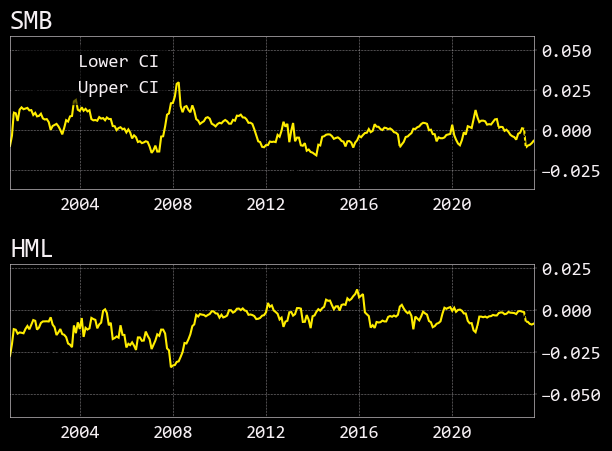

In [10]:
"""Put the active returns and factors into a DataFrame to make it easy to align the dates. 
Then run a regression with the active returns as the dependent variable on the factors. 
Fitting the model gives you the two coefficients that determine the sensitivities 
of the portfolio’s active returns to the factors.
The sensitivities are estimates so it’s important to see how they evolve through time.
"""

exog_vars = ["SMB", "HML"]
exog = sm.add_constant(factors[exog_vars])
rols = RollingOLS(df.R, exog, window = 12)
rres= rols.fit()
fig = rres.plot_recursive_coefficient(variables = exog_vars)

In [11]:
"""Marginal Contribution To Active Risk (MCTAR) measures the incremental active risk 
each additional factor introduces to your portfolio.
"""

F1 = df.F1
F2 = df.F2

cov =np.cov(F1, F2)
ar_squared = (active.std())**2
mcar1 = (b1 * (b2 * cov[0,1] + b1 * cov[0,0])) / ar_squared
mcar2 = (b2 * (b1 * cov[0,1] + b2 * cov[1,1])) / ar_squared
print(f'SMB risk Contribution: {mcar1}')
print(f'HML risk Contribution: {mcar2}')
print(f'Unexplained Risk Contribution: {1 - (mcar1 + mcar2)}')

SMB risk Contribution: 0.019621104515084177
HML risk Contribution: 0.13985649432186745
Unexplained Risk Contribution: 0.8405224011630483
